In [90]:
from pathlib import Path
import requests
import string
from collections import Counter, defaultdict


import matplotlib.pyplot as plt
import numpy as np

In [43]:
data_path = Path('data')

In [44]:
shakespeare_path = data_path / 'Shakespeare.txt'
if not shakespeare_path.exists():
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    response = requests.get(url)
    shakespeare_path.write_text(response.text)


In [45]:
with open(shakespeare_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [46]:
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [173]:
def simplify_text(text):
    text = text.lower().strip()  # Convert to lowercase and remove leading/trailing white spaces
    text = text.replace('\n', ' ')  # Replace newline characters with a space
    text = text.replace('\r', ' ')  # Replace carriage return characters with a space
    
    # Remove punctuation
    text = ''.join(char for char in text if char not in string.punctuation)
    
    # Replace multiple spaces with a single space
    text = ' '.join(text.split())
    # remove numbers
    text = ''.join(char for char in text if not char.isdigit())
    
    return text

In [174]:
def unique_characters(text):
    return len(set(text))

def n_gram_statistics(text, n, normalize=False):
    n_gram_counter = Counter(text[i:i+n] for i in range(len(text) - n + 1))
    
    if normalize:
        total = sum(n_gram_counter.values())
        return n_gram_counter, {k: v / total for k, v in n_gram_counter.items()}
    else:
        return n_gram_counter
    
    
def normalize_ngram_counts(n_gram_counter):
    # Create a defaultdict to hold the conditional probabilities
    normalized_ngrams = defaultdict(float)
    
    # Create a defaultdict to hold the sum of counts for each context
    context_totals = defaultdict(int)
    
    # First loop through to calculate the total counts for each context
    for ngram, count in n_gram_counter.items():
        context = ngram[:-1]
        context_totals[context] += count

    # Second loop through to normalize
    for ngram, count in n_gram_counter.items():
        context = ngram[:-1]
        normalized_ngrams[ngram] = count / context_totals[context]

    return normalized_ngrams

## Prepare a chunk of text for n-gram analysis

In [212]:
text_chunk_size = len(data)

print(f'percent of the full corpus: {text_chunk_size / len(data):.2%} %')

percent of the full corpus: 100.00% %


In [213]:
text = simplify_text(data[:text_chunk_size])
len(text)

1053723

In [214]:
alphabet_len = unique_characters(text)
print(f"Number of unique characters: {alphabet_len}")

Number of unique characters: 27


In [215]:
actual_n_grams = []
computed_n_grams = defaultdict(dict)
normalized_n_grams = defaultdict(dict)

# Compute and store n-gram statistics up to 10-grams
for n in range(1, 11):
    actual_ngram_counter, norm_ngram_counter = n_gram_statistics(text, n, normalize=True)
    actual_count = len(actual_ngram_counter)
    

    actual_n_grams.append(actual_count)
    print(f"{n :2}-grams: {actual_count:,}")
    
    # Store the computed n-grams in the dictionary
    computed_n_grams[n] = actual_ngram_counter
    normalized_n_grams[n] = norm_ngram_counter

    


 1-grams: 27
 2-grams: 546
 3-grams: 5,193
 4-grams: 24,176
 5-grams: 77,032
 6-grams: 182,784
 7-grams: 324,458
 8-grams: 480,065
 9-grams: 630,035
10-grams: 753,843


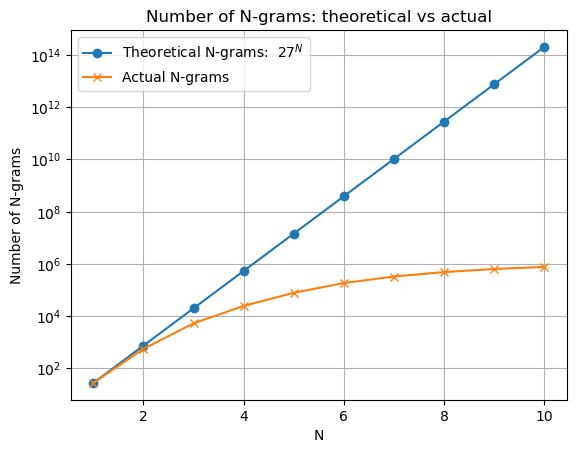

In [218]:
Ns = np.arange(1,11)
plt.plot(Ns, alphabet_len**Ns, label='Theoretical N-grams:  $27^N$', marker='o')
plt.plot(Ns, actual_n_grams, label='Actual N-grams', marker='x')
plt.xlabel('N')
plt.ylabel('Number of N-grams')
plt.title('Number of N-grams: theoretical vs actual')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

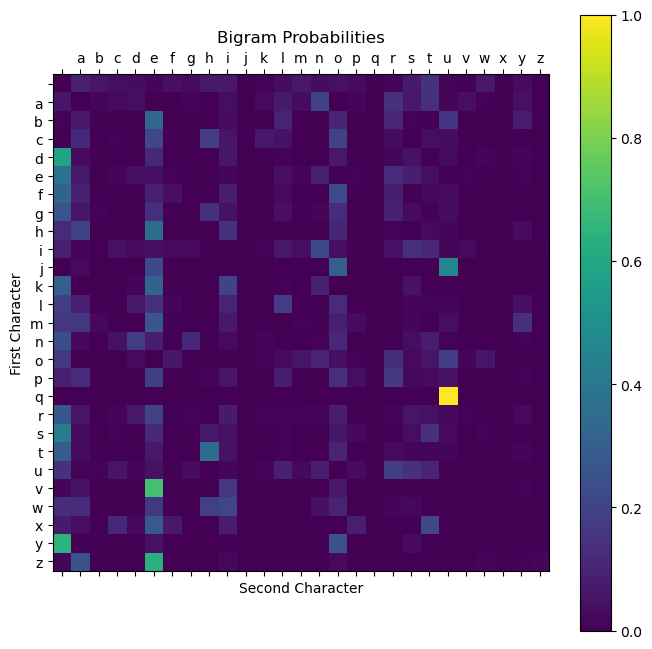

In [180]:
# Extract bigram probabilities from computed_n_grams
bigram_probabilities = normalize_ngram_counts(computed_n_grams[2])

# Extract the unique characters to define dimensions of the square table
unique_chars = sorted(list(set([char for bigram in bigram_probabilities.keys() for char in bigram])))

# Create an empty matrix filled with zeros
matrix_size = len(unique_chars)
bigram_matrix = np.zeros((matrix_size, matrix_size))

# Create a mapping from unique characters to indices
char_to_index = {char: index for index, char in enumerate(unique_chars)}

# Fill in the matrix with bigram probabilities
for bigram, probability in bigram_probabilities.items():
    x, y = bigram
    bigram_matrix[char_to_index[x], char_to_index[y]] = probability

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Create a heatmap
cax = ax.matshow(bigram_matrix, cmap="viridis")

# Add a colorbar
fig.colorbar(cax)

# Annotate the cells with probabilities
for i in range(matrix_size):
    for j in range(matrix_size):
        c = bigram_matrix[j, i]
        # ax.text(i, j, str(round(c, 2)), va='center', ha='center')

# Set axis labels
ax.set_xticks(np.arange(len(unique_chars)))
ax.set_yticks(np.arange(len(unique_chars)))
ax.set_xticklabels(unique_chars)
ax.set_yticklabels(unique_chars)

# Add labels and title
plt.xlabel('Second Character')
plt.ylabel('First Character')
plt.title('Bigram Probabilities')

plt.show()


In [193]:
bigram_matrix[char_to_index['q'], char_to_index['u']]

1.0

## Computing entropy of N-grams

In [194]:
def compute_entropy(probabilities):
    return -np.sum([p * np.log(p) for p in probabilities])

In [195]:


# Initialize a dictionary to store the entropy values for each 'n'
ngram_entropies = {}
print(f'{0:2}, entropy: {np.log(alphabet_len):.3f} : uniform distribution')

# Compute entropy for each set of n-grams
for n, ngram_probabilities in normalized_n_grams.items():
    entropy = compute_entropy(list(ngram_probabilities.values()))
    ngram_entropies[n] = entropy
    print(f'{n:2}, entropy: {entropy:.3f}, entropy per character: {entropy / n:.3f}')

# Now, ngram_entropies[n] will give you the entropy for the n-grams when 'n' is specified.
# For example, ngram_entropies[2] will give you the entropy for bigrams.


 0, entropy: 3.296 : uniform distribution
 1, entropy: 2.839, entropy per character: 2.839
 2, entropy: 5.150, entropy per character: 2.575
 3, entropy: 7.012, entropy per character: 2.337
 4, entropy: 8.496, entropy per character: 2.124
 5, entropy: 9.740, entropy per character: 1.948
 6, entropy: 10.795, entropy per character: 1.799
 7, entropy: 11.657, entropy per character: 1.665
 8, entropy: 12.326, entropy per character: 1.541
 9, entropy: 12.809, entropy per character: 1.423
10, entropy: 13.139, entropy per character: 1.314


In [238]:
print('in Shannons')
# Compute entropy for each set of n-grams
for n, entropy in ngram_entropies.items():
    entropy2 = 1/np.log(2) * entropy
    if n > 1:
        Fn = entropy2 - 1/np.log(2) * ngram_entropies[n-1]
    else:
        Fn = entropy2
    print(f'{n:2}, entropy: {entropy2:.3f}, entropy/n: {entropy2 / n:.3f}, Fn: {Fn:.3f}')

in Shannons
 1, entropy: 4.096, entropy/n: 4.096, Fn: 4.096
 2, entropy: 7.430, entropy/n: 3.715, Fn: 3.334
 3, entropy: 10.117, entropy/n: 3.372, Fn: 2.686
 4, entropy: 12.258, entropy/n: 3.064, Fn: 2.141
 5, entropy: 14.052, entropy/n: 2.810, Fn: 1.794
 6, entropy: 15.574, entropy/n: 2.596, Fn: 1.522
 7, entropy: 16.818, entropy/n: 2.403, Fn: 1.244
 8, entropy: 17.783, entropy/n: 2.223, Fn: 0.965
 9, entropy: 18.479, entropy/n: 2.053, Fn: 0.697
10, entropy: 18.956, entropy/n: 1.896, Fn: 0.477


In [197]:

def sample_from_ngrams(n, ngram_probabilities, seed, length=100):
    if len(seed) < n - 1:
        raise ValueError("Seed must be at least (n-1) characters long.")

    # Initialize the generated text with the seed
    generated_text = seed

    # Loop to generate 'length' number of characters
    for _ in range(length):
        # Extract the last (n-1) characters as context for the next character
        context = generated_text[-(n - 1):]

        # Get the possible next characters and their probabilities
        possible_next_chars = [k[-1] for k, v in ngram_probabilities.items() if k.startswith(context)]
        probabilities = [v for k, v in ngram_probabilities.items() if k.startswith(context)]

        if not possible_next_chars:
            # If no possible next characters, break the loop
            break

        # Sample the next character based on the probabilities
        next_char = np.random.choice(possible_next_chars, p=probabilities)
        
        # Append the next character to the generated text
        generated_text += next_char

    return generated_text




In [226]:
# Example usage
n = 10  # bigrams
seed = "to be or not to be"  # Must be at least (n-1) characters
length = 200  # Length of generated text
ngram_probabilities = normalize_ngram_counts(computed_n_grams[n])

generated_text = sample_from_ngrams(n, ngram_probabilities, seed, length)
print(generated_text)

to be or not to be endured sirrah go you to juliet how now whats the first thing about the making of their terror escalus we shall be so cominius whos yonder tower or walk in thievish ways or bid me lurk where serpents
